# Customer Churn Analysis (Northwind)

## 1. Imports

In [ ]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

## 2. Load Data

In [8]:

DB_PATH = r"northwind-SQLite3-main\dist\northwind.db"
conn = sqlite3.connect(DB_PATH)
sales = pd.read_sql("SELECT o.OrderID,o.CustomerID,o.OrderDate,od.UnitPrice,od.Quantity FROM Orders o JOIN [Order Details] od ON o.OrderID = od.OrderID", conn)
sales["OrderDate"] = pd.to_datetime(sales["OrderDate"], errors='coerce')
sales.head()


,OrderID,CustomerID,OrderDate,UnitPrice,Quantity
0,10248,VINET,2016-07-04,14.0,12
1,10248,VINET,2016-07-04,9.8,10
2,10248,VINET,2016-07-04,34.8,5
3,10249,TOMSP,2016-07-05,18.6,9
4,10249,TOMSP,2016-07-05,42.4,40


## 3. Define Churn
A customer is churned if they made no purchase in the last 6 months.

In [9]:

reference_date = sales['OrderDate'].max()
customer_last = sales.groupby('CustomerID')['OrderDate'].max().reset_index()

customer_last['days_since_last_order'] = (
    reference_date - customer_last['OrderDate']
).dt.days

customer_last['churn'] = customer_last['days_since_last_order'] > 180
customer_last.head()


,CustomerID,OrderDate,days_since_last_order,churn
0,ALFKI,2018-04-09,27.0,False
1,ANATR,2018-03-04,63.0,False
2,ANTON,2018-01-28,98.0,False
3,AROUT,2018-04-10,26.0,False
4,BERGS,2018-03-04,63.0,False


In [24]:
churned_customers = df[df["churn"] == True]

In [25]:
bins = [0, 30, 60, 90, 120, 180, 365, 1000]
labels = [
    "0–30 days",
    "31–60 days",
    "61–90 days",
    "91–120 days",
    "121–180 days",
    "181–365 days",
    "365+ days"
]

churned_customers["inactivity_bucket"] = pd.cut(
    churned_customers["days_since_last_order"],
    bins=bins,
    labels=labels
)

churned_customers["inactivity_bucket"].value_counts()


C:\Users\ssc\AppData\Local\Temp\ipykernel_11744\1995282795.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  churned_customers["inactivity_bucket"] = pd.cut(


inactivity_bucket
181–365 days    4
365+ days       1
0–30 days       0
31–60 days      0
61–90 days      0
91–120 days     0
121–180 days    0
Name: count, dtype: int64

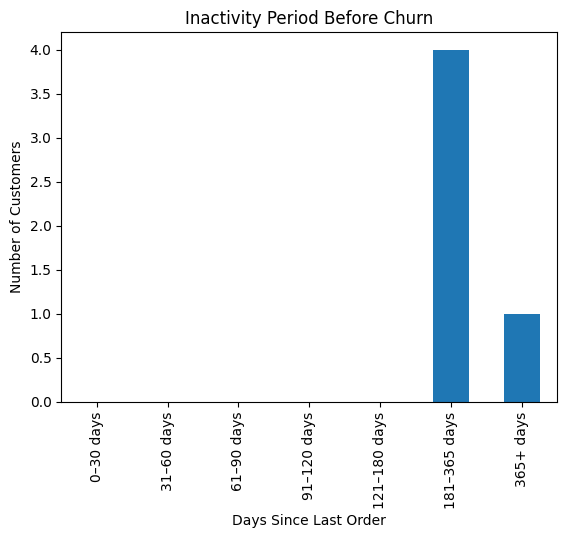

In [26]:
churned_customers["inactivity_bucket"].value_counts().sort_index().plot(
    kind="bar",
    title="Inactivity Period Before Churn"
)
plt.ylabel("Number of Customers")
plt.xlabel("Days Since Last Order")
plt.show()

## 4. Feature Engineering

In [10]:

features = sales.groupby('CustomerID').agg(
    total_orders=('OrderID', 'nunique'),
    total_revenue=('UnitPrice', 'sum'),
    avg_quantity=('Quantity', 'mean')
).reset_index()

df = features.merge(customer_last[['CustomerID','churn']], on='CustomerID')
df.head()


,CustomerID,total_orders,total_revenue,avg_quantity,churn
0,ALFKI,163,155494.52,25.748169,False
1,ANATR,195,216049.26,25.472055,False
2,ANTON,163,170308.47,25.703716,False
3,AROUT,156,170035.40,25.346915,False
4,BERGS,178,189350.47,25.554364,False


## 5. Exploratory Data Analysis

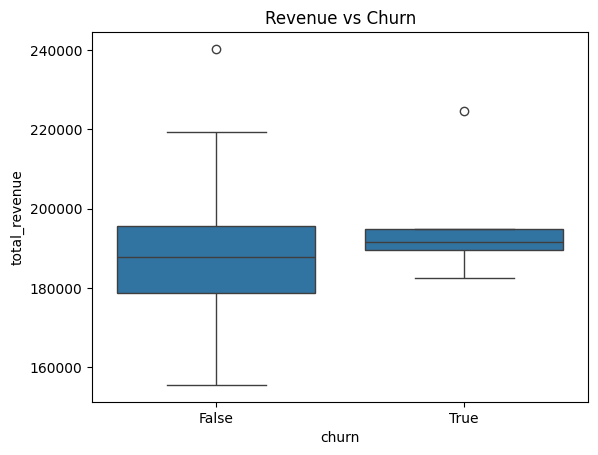

In [11]:

sns.boxplot(x='churn', y='total_revenue', data=df)
plt.title("Revenue vs Churn")
plt.show()


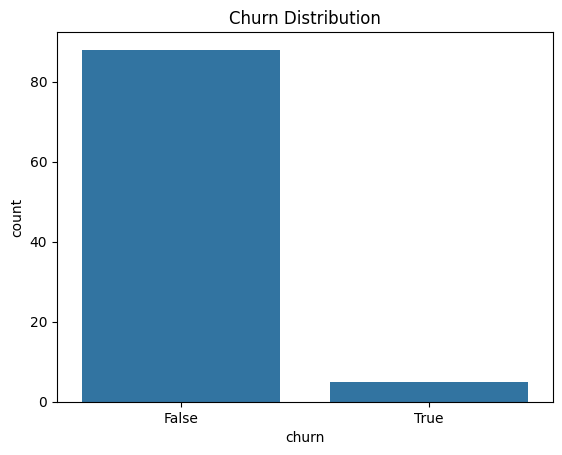

churn
False    0.946237
True     0.053763
Name: proportion, dtype: float64


In [21]:
sns.countplot(x='churn', data=df)
plt.title("Churn Distribution")
plt.show()

print(df['churn'].value_counts(normalize=True))


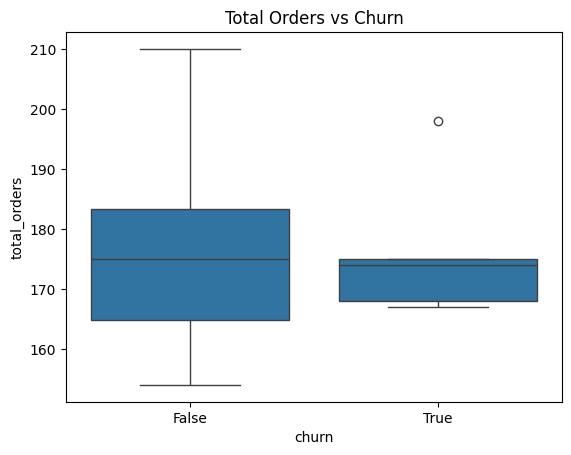

In [22]:
sns.boxplot(x='churn', y='total_orders', data=df)
plt.title("Total Orders vs Churn")
plt.show()


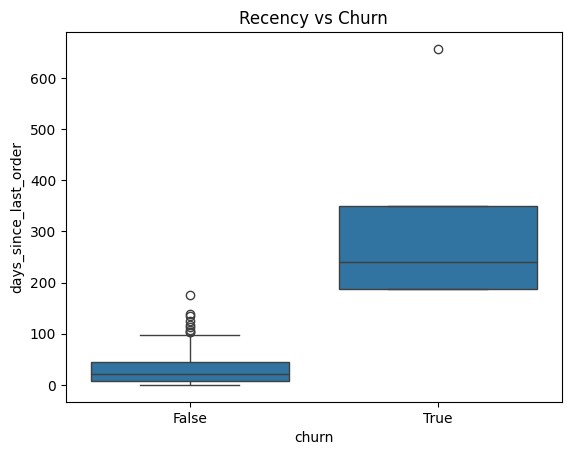

In [23]:
df = df.merge(
    customer_last[['CustomerID','days_since_last_order']],
    on='CustomerID'
)

sns.boxplot(x='churn', y='days_since_last_order', data=df)
plt.title("Recency vs Churn")
plt.show()


## 6. Modeling

In [12]:

X = df.drop(['CustomerID','churn'], axis=1)
y = df['churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)


## 7. Evaluation

In [13]:

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))


c:\Users\ssc\miniconda3\envs\data_analysis\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ssc\miniconda3\envs\data_analysis\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ssc\miniconda3\envs\data_analysis\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

              precision    recall  f1-score   support

       False       0.95      1.00      0.97        18
        True       0.00      0.00      0.00         1

    accuracy                           0.95        19
   macro avg       0.47      0.50      0.49        19
weighted avg       0.90      0.95      0.92        19

ROC AUC: 0.2777777777777778


In [16]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(class_weight='balanced', max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)


In [17]:
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))

              precision    recall  f1-score   support

       False       1.00      0.50      0.67        18
        True       0.10      1.00      0.18         1

    accuracy                           0.53        19
   macro avg       0.55      0.75      0.42        19
weighted avg       0.95      0.53      0.64        19

ROC AUC: 0.8888888888888888


In [19]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(class_weight='balanced', max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)


In [20]:
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))

              precision    recall  f1-score   support

       False       1.00      0.50      0.67        18
        True       0.10      1.00      0.18         1

    accuracy                           0.53        19
   macro avg       0.55      0.75      0.42        19
weighted avg       0.95      0.53      0.64        19

ROC AUC: 0.8888888888888888


## 8. Business Insights
- Low-frequency customers are more likely to churn
- Retention campaigns should target inactive users early